In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import warnings


In [2]:
# Function to load images and labels
def load_images_and_labels(folder_path):
    data, labels = [], []
    for subfolder in ["sushi", "cheesecake", "baklava", "caesar_salad", "hamburger"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".jpg"):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (128, 128))
                    data.append(img)
                    labels.append(subfolder.lower())
    return np.array(data), np.array(labels)


In [3]:
# HOG feature extraction function
def extract_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    fd, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), 
                cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256]).flatten()
    combined_features = np.hstack((fd, color_hist))
    return combined_features


In [4]:
# Folder path
folder_path = r'D:\food_set\food_set'
images, labels = load_images_and_labels(folder_path)


In [5]:
# Show dataset information
print(f"Number of Classes: {len(np.unique(labels))}")
print(f"Class Labels: {np.unique(labels)}")
print(f"Total Samples in Dataset: {len(images)}")
print(f"Image Size: {images[0].shape if len(images) > 0 else 'N/A'}")


Number of Classes: 5
Class Labels: ['baklava' 'caesar_salad' 'cheesecake' 'hamburger' 'sushi']
Total Samples in Dataset: 5000
Image Size: (128, 128, 3)


In [6]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
augmented_data, augmented_labels = [], []
for img, label in zip(images, labels):
    img = np.expand_dims(img, axis=0)
    for aug_img in datagen.flow(img, batch_size=1):
        augmented_data.append(aug_img[0].astype('uint8'))
        augmented_labels.append(label)
        if len(augmented_data) >= 2 * len(images):
            break
images = np.array(augmented_data)
labels = np.array(augmented_labels)


In [7]:
# Extract combined features
features = np.array([extract_features(img) for img in images])


In [8]:
# Encode labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)


In [10]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [11]:
from imblearn.over_sampling import SMOTE

# Instantiate and apply SMOTE
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, numeric_labels)


In [12]:
# Normalize features and apply PCA
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_resampled)

pca = PCA(n_components=100)
pca_features = pca.fit_transform(normalized_features)


In [13]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(pca_features, labels_resampled, test_size=0.2, random_state=42)

# Show dataset split information
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")


Training Samples: 43996
Testing Samples: 10999


In [14]:
# Hyperparameter tuning for KNN
param_grid = {
    'n_neighbors': list(range(3, 20)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [15]:
# Evaluate the best KNN model
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Best Parameters:", grid_search.best_params_)


Test Accuracy: 0.982089280843713
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


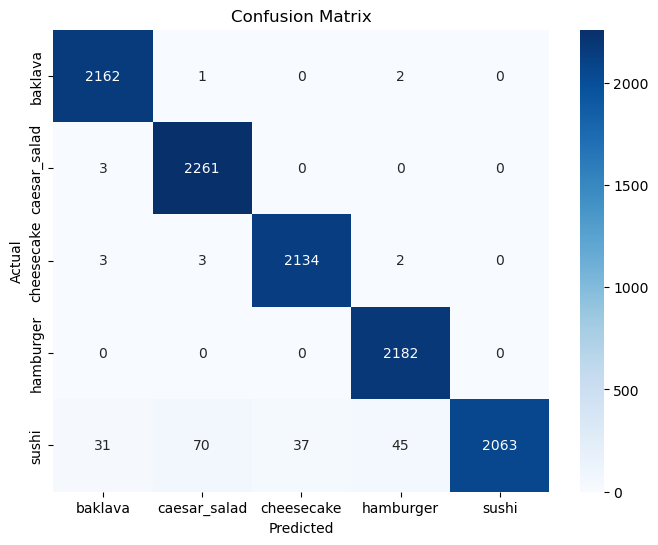

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


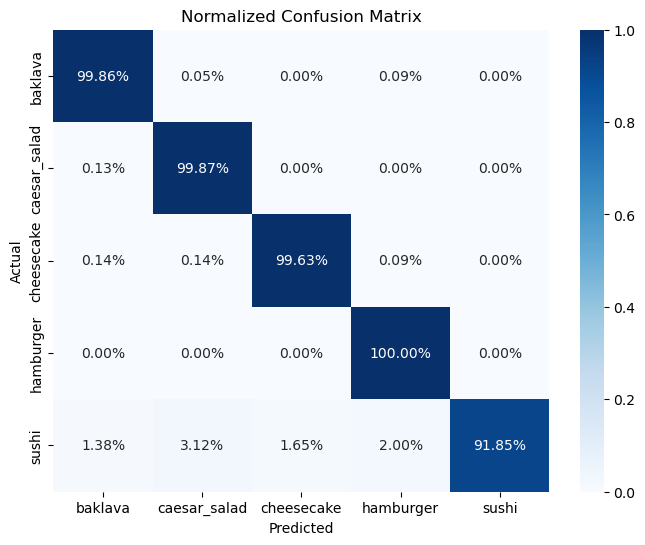

In [17]:
# Normalize the confusion matrix for better readability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     baklava       0.98      1.00      0.99      2165
caesar_salad       0.97      1.00      0.98      2264
  cheesecake       0.98      1.00      0.99      2142
   hamburger       0.98      1.00      0.99      2182
       sushi       1.00      0.92      0.96      2246

    accuracy                           0.98     10999
   macro avg       0.98      0.98      0.98     10999
weighted avg       0.98      0.98      0.98     10999



In [19]:
# Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
metrics_df = pd.DataFrame({
    "Class": label_encoder.classes_,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
})
print(metrics_df)


          Class  Precision    Recall  F1-Score
0       baklava   0.983174  0.998614  0.990834
1  caesar_salad   0.968308  0.998675  0.983257
2    cheesecake   0.982957  0.996265  0.989566
3     hamburger   0.978037  1.000000  0.988896
4         sushi   1.000000  0.918522  0.957531


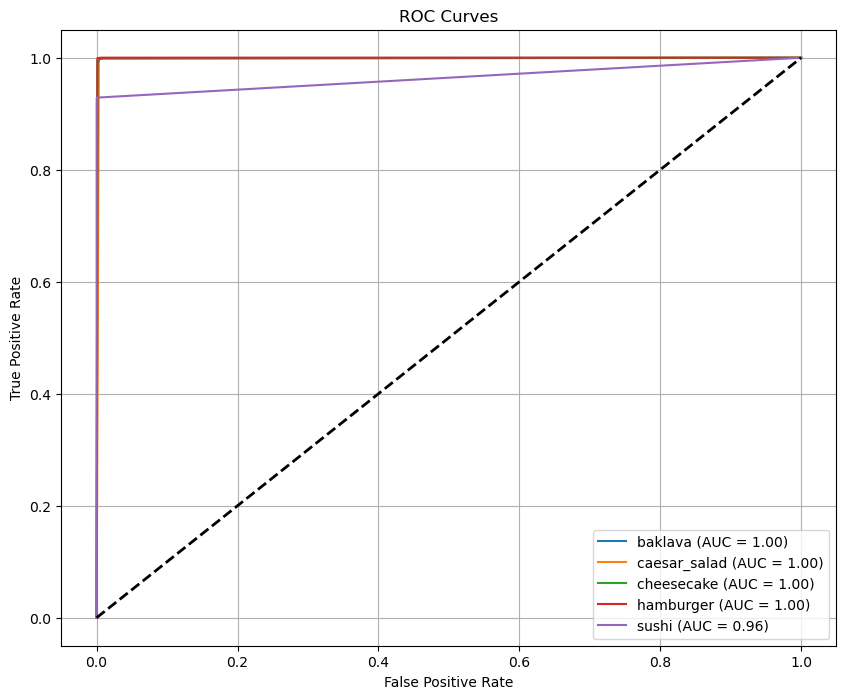

In [20]:
# ROC and AUC Curves
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_score = grid_search.best_estimator_.predict_proba(X_test)

plt.figure(figsize=(10, 8))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [21]:
# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.2f}")


Balanced Accuracy: 0.98


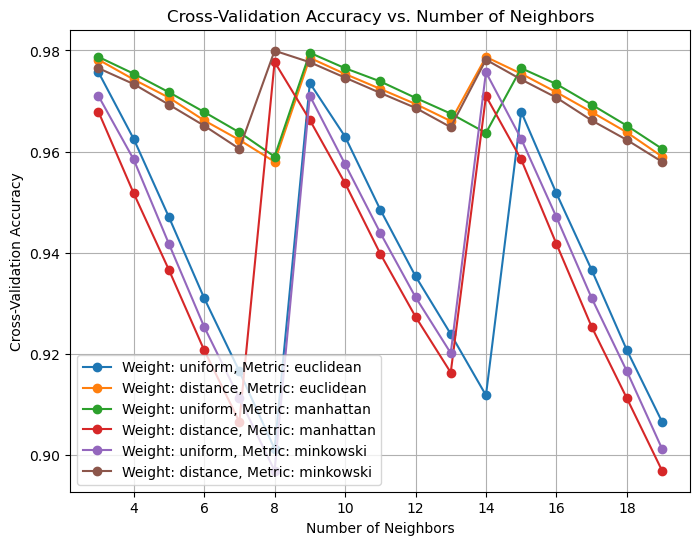

In [23]:
# Get results from grid search
results = grid_search.cv_results_

# Extract mean test scores and reshape them
mean_test_scores = results['mean_test_score']
param_grid_n_neighbors = param_grid['n_neighbors']

# Reshape mean_test_scores for the different combinations of other hyperparameters
# This assumes the 'n_neighbors' varies fastest in the grid
# We can reshape mean_test_scores to match the grid's dimensions: (len(n_neighbors), len(weights), len(metrics))

# Get the number of unique values for 'weights' and 'metric' in param_grid
n_neighbors_count = len(param_grid_n_neighbors)
weights_count = len(param_grid['weights'])
metrics_count = len(param_grid['metric'])

# Reshape the results (this assumes that 'n_neighbors' is the first axis of the grid search)
mean_test_scores_reshaped = mean_test_scores.reshape(n_neighbors_count, weights_count, metrics_count)

# Now plot the results for each 'metric' and 'weights' combination
plt.figure(figsize=(8, 6))
for i, metric in enumerate(param_grid['metric']):
    for j, weight in enumerate(param_grid['weights']):
        plt.plot(param_grid_n_neighbors, mean_test_scores_reshaped[:, j, i], marker='o', label=f'Weight: {weight}, Metric: {metric}')
        
plt.title("Cross-Validation Accuracy vs. Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Cross-Validation Accuracy")
plt.legend()
plt.grid()
plt.show()
